In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


%matplotlib inline

In [2]:
file_name = "airbnb_session_data.txt"
df = pd.read_csv(file_name, delimiter ='|', parse_dates=['ds','ts_max','ts_min','next_ts_max','next_ts_min'])

In [3]:
boolean_columns = [
    'did_search', 
    'sent_message',
    'sent_booking_request', 
    'next_did_search',
    'next_sent_message',
    'next_sent_booking_request'
]
df[boolean_columns] = df[boolean_columns].astype(bool)

In [4]:
# session duration is in Minutes
df['session_duration'] = (df['ts_max'] - df['ts_min']) / np.timedelta64(1, 'm')
df['next_session_duration'] = (df['next_ts_max'] - df['next_ts_min']) / np.timedelta64(1, 'm')

df.columns

Index(['id_visitor', 'id_session', 'dim_session_number', 'dim_user_agent',
       'dim_device_app_combo', 'ds', 'ts_min', 'ts_max', 'did_search',
       'sent_message', 'sent_booking_request', 'next_id_session',
       'next_dim_session_number', 'next_dim_user_agent',
       'next_dim_device_app_combo', 'next_ds', 'next_ts_min', 'next_ts_max',
       'next_did_search', 'next_sent_message', 'next_sent_booking_request',
       'session_duration', 'next_session_duration'],
      dtype='object')

In [5]:
session_df = df[['dim_session_number', 
                 'session_duration',
                 'next_session_duration',
                 'did_search', 
                 'sent_message',
                 'sent_booking_request',
                 'next_id_session',
                 'next_did_search',
                 'next_sent_message',
                 'next_sent_booking_request',
                 'dim_device_app_combo',
                 'id_visitor'
                ]]

session_df.tail(3)

,dim_session_number,session_duration,next_session_duration,did_search,sent_message,sent_booking_request,next_id_session,next_did_search,next_sent_message,next_sent_booking_request,dim_device_app_combo,id_visitor
7753,5,10.700000,0.483333,True,False,False,7ad89a28468df5bab4c4244588806960,False,False,False,iPad - Web,1414271365_EuFmeZ+vsDuryP8F
7754,6,0.483333,NaN,False,False,False,NaN,True,True,True,iPad - Web,1414271365_EuFmeZ+vsDuryP8F
7755,1,0.000000,NaN,False,False,False,NaN,True,True,True,Desktop - Chrome,1416012256_dB6ft6mhjVRXX48c


In [6]:
session_df.loc[:, 'device'] = session_df['dim_device_app_combo'].map(lambda x: x.split('-')[0])
session_df.loc[:, 'app'] = session_df['dim_device_app_combo'].map(lambda x: x.split('-')[1])

session_df.loc[:, 'has_next_session'] = pd.notnull(df['next_id_session'])

session_df.tail(3)

/usr/local/lib/python3.4/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,dim_session_number,session_duration,next_session_duration,did_search,sent_message,sent_booking_request,next_id_session,next_did_search,next_sent_message,next_sent_booking_request,dim_device_app_combo,id_visitor,device,app,has_next_session
7753,5,10.700000,0.483333,True,False,False,7ad89a28468df5bab4c4244588806960,False,False,False,iPad - Web,1414271365_EuFmeZ+vsDuryP8F,iPad,Web,True
7754,6,0.483333,NaN,False,False,False,NaN,True,True,True,iPad - Web,1414271365_EuFmeZ+vsDuryP8F,iPad,Web,False
7755,1,0.000000,NaN,False,False,False,NaN,True,True,True,Desktop - Chrome,1416012256_dB6ft6mhjVRXX48c,Desktop,Chrome,False


In [7]:
groupby_device = session_df.groupby(['device'])
groupby_app = session_df.groupby(['app'])
groupby_app_device = session_df.groupby(['dim_device_app_combo'])
percent_function = lambda x: np.sum(x) / len(x)

agg_functions = {"count": np.sum, "rate": percent_function}
stats_functions = {'mean': np.mean, 'std': np.std}

agg = {'sent_booking_request':agg_functions,\
       'sent_message':agg_functions,\
       'did_search':agg_functions,\
       'has_next_session': agg_functions,\
       'dim_session_number': stats_functions,\
       'session_duration': stats_functions,\
       'device': {'count': len},\
       'app': {'count': len},\
       'id_visitor': {'uniq_count': lambda x: len(set(x))},\
      }

In [8]:
device_df = groupby_device.agg(agg)
device_df.columns = ['_'.join(col).strip() for col in device_df.columns.values]
device_df.reset_index(level=0, inplace=True)
device_df


,device,did_search_rate,did_search_count,device_count,sent_booking_request_rate,sent_booking_request_count,app_count,sent_message_rate,sent_message_count,id_visitor_uniq_count,has_next_session_rate,has_next_session_count,dim_session_number_std,dim_session_number_mean,session_duration_std,session_duration_mean
0,Android Phone,0.129134,82,635,0.009449,6,635,0.182677,116,38,0.962205,611,43.168884,52.162205,22.002976,11.491601
1,Android Tablet,0.060317,19,315,0.003175,1,315,0.330159,104,16,0.961905,303,108.861701,142.736508,10.811998,7.257354
2,Desktop,0.297059,707,2380,0.044538,106,2380,0.242857,578,427,0.837815,1994,78.442936,50.457983,21.075992,12.585840
3,Other,0.018727,5,267,0.003745,1,267,0.022472,6,48,0.951311,254,77.308701,67.329588,10.755812,3.103246
4,Unknown,0.040984,5,122,0.000000,0,122,0.000000,0,41,0.885246,108,21.453575,16.286885,5.498257,2.630055
5,iPad,0.279026,149,534,0.016854,9,534,0.131086,70,97,0.852060,455,34.456582,27.159176,26.951990,13.476654
6,iPhone,0.076791,269,3503,0.006280,22,3503,0.115615,405,141,0.970882,3401,161.646408,150.772766,33.440453,10.120073


In [9]:
app_df = groupby_app.agg(agg)
app_df.columns = ['_'.join(col).strip() for col in app_df.columns.values]
app_df.reset_index(level=0, inplace=True)
app_df.tail(10)

,app,did_search_rate,did_search_count,device_count,sent_booking_request_rate,sent_booking_request_count,app_count,sent_message_rate,sent_message_count,id_visitor_uniq_count,has_next_session_rate,has_next_session_count,dim_session_number_std,dim_session_number_mean,session_duration_std,session_duration_mean
0,Android,0.176344,82,465,0.012903,6,465,0.193548,90,19,0.974194,453,35.047692,46.281720,24.733499,14.224086
1,Chrome,0.270110,319,1181,0.047417,56,1181,0.230313,272,191,0.863675,1020,77.628471,49.279424,18.670673,11.133460
2,Firefox,0.382263,125,327,0.061162,20,327,0.229358,75,72,0.840979,275,46.802021,29.758410,28.509182,17.280326
3,IE,0.216783,93,429,0.025641,11,429,0.310023,133,78,0.848485,364,100.233808,78.037296,17.419504,11.143046
4,Moweb,0.016000,10,625,0.003200,2,625,0.080000,50,111,0.924800,578,161.925015,116.198400,15.387098,3.363467
5,Other,0.018727,5,267,0.003745,1,267,0.022472,6,48,0.951311,254,77.308701,67.329588,10.755812,3.103246
6,Safari,0.383747,170,443,0.042889,19,443,0.221219,98,127,0.756208,335,67.522461,42.171558,23.230907,14.389729
7,Web,0.072964,129,1768,0.003959,7,1768,0.088235,156,202,0.928733,1642,145.849763,128.363122,29.807038,8.766610
8,iOS,0.134607,303,2251,0.010218,23,2251,0.177255,399,71,0.979565,2205,151.722295,134.003110,34.074856,12.587968


In [10]:
app_device_df = groupby_app_device.agg(agg)
app_device_df.columns = ['_'.join(col).strip() for col in app_device_df.columns.values]
app_device_df.reset_index(level=1, inplace=True)
app_device_df.loc[:, 'device'] = app_device_df['dim_device_app_combo'].map(lambda x: x.split('-')[0])
app_device_df.loc[:, 'app'] = app_device_df['dim_device_app_combo'].map(lambda x: x.split('-')[1])
app_device_df

,dim_device_app_combo,did_search_rate,did_search_count,device_count,sent_booking_request_rate,sent_booking_request_count,app_count,sent_message_rate,sent_message_count,id_visitor_uniq_count,has_next_session_rate,has_next_session_count,dim_session_number_std,dim_session_number_mean,session_duration_std,session_duration_mean,device,app
0,Android Phone - Android,0.179601,81,451,0.013304,6,451,0.192905,87,18,0.977827,441,35.290570,47.011086,25.005423,14.277162,Android Phone,Android
1,Android Phone - Moweb,0.000000,0,72,0.000000,0,72,0.319444,23,20,0.888889,64,46.588189,55.361111,9.240396,5.254398,Android Phone,Moweb
2,Android Phone - Web,0.008929,1,112,0.000000,0,112,0.053571,6,25,0.946429,106,61.155423,70.848214,8.157488,4.284375,Android Phone,Web
3,Android Tablet - Android,0.071429,1,14,0.000000,0,14,0.214286,3,2,0.857143,12,10.885266,22.785714,13.688600,12.514286,Android Tablet,Android
4,Android Tablet - Moweb,0.000000,0,2,0.000000,0,2,0.000000,0,1,1.000000,2,0.707107,22.500000,1.838478,5.216667,Android Tablet,Moweb
5,Android Tablet - Web,0.060201,18,299,0.003344,1,299,0.337793,101,15,0.966555,289,108.016864,149.157191,10.658787,7.024861,Android Tablet,Web
6,Desktop - Chrome,0.270110,319,1181,0.047417,56,1181,0.230313,272,191,0.863675,1020,77.628471,49.279424,18.670673,11.133460,Desktop,Chrome
7,Desktop - Firefox,0.382263,125,327,0.061162,20,327,0.229358,75,72,0.840979,275,46.802021,29.758410,28.509182,17.280326,Desktop,Firefox
8,Desktop - IE,0.216783,93,429,0.025641,11,429,0.310023,133,78,0.848485,364,100.233808,78.037296,17.419504,11.143046,Desktop,IE
9,Desktop - Safari,0.383747,170,443,0.042889,19,443,0.221219,98,127,0.756208,335,67.522461,42.171558,23.230907,14.389729,Desktop,Safari


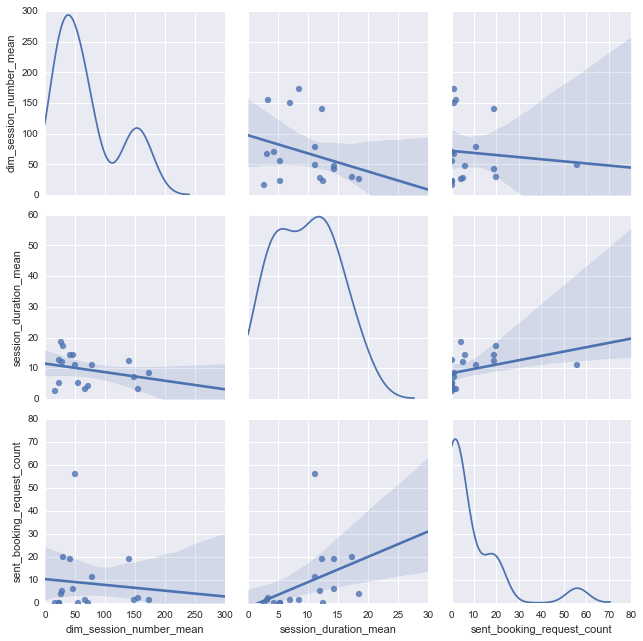

In [11]:
plot_vars = [
    'dim_session_number_mean',
    'session_duration_mean',
    'sent_booking_request_count'
]

plots = sb.pairplot(app_device_df, 
                    vars=plot_vars, 
                    diag_kind='kde', 
                    kind='reg', 
                    size=3,
                    plot_kws={'scatter_kws':{"s": 40}}
                   )
plots.set(ylim=(0, None), xlim=(0,None))


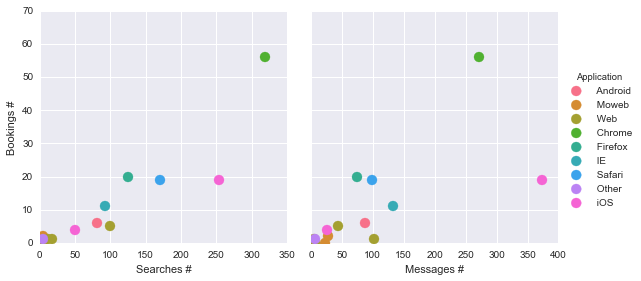

In [215]:
all_vars = [
    'did_search_count',
    'sent_message_count',
    'sent_booking_request_count',
    'app',
    'device'
]


plot_df = app_device_df[all_vars]
plot_df.tail(3)
plot_df.columns = ['Searches Done', 'Messages Sent', 'Booking Sent', 'Application','Device']
plots = sb.pairplot(plot_df, 
            x_vars=['Searches Done', 'Messages Sent'],
            y_vars='Booking Sent', 
            hue='Application', 
            size=4, 
            plot_kws={"s": 100}
           ).set(ylim=(0, None), xlim=(0,None))
new_ables = [
    {'title': "", 'x_title': 'Searches #', 'y_title': 'Bookings #'},
    {'title': "", 'x_title': 'Messages #', 'y_title': ''}
]

for ax, axes in zip(plots.axes.flat, new_ables):
   ax.set_title(axes['title'])
   ax.set_ylabel(axes['y_title'])
   ax.set_xlabel(axes['x_title'])



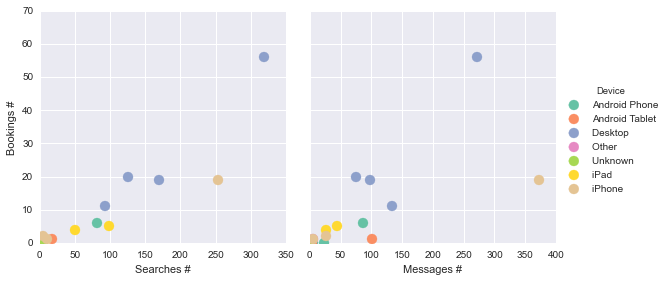

In [217]:
plots = sb.pairplot(plot_df,
            x_vars=['Searches Done', 'Messages Sent'],
            y_vars='Booking Sent', 
            hue='Device',
            size=4,
            palette="Set2",
            plot_kws={"s": 100}
           ).set(ylim=(0, None), xlim=(0,None))

new_ables = [
    {'title': "", 'x_title': 'Searches #', 'y_title': 'Bookings #'},
    {'title': "", 'x_title': 'Messages #', 'y_title': ''}
]

for ax, axes in zip(plots.axes.flat, new_ables):
   ax.set_title(axes['title'])
   ax.set_ylabel(axes['y_title'])
   ax.set_xlabel(axes['x_title'])


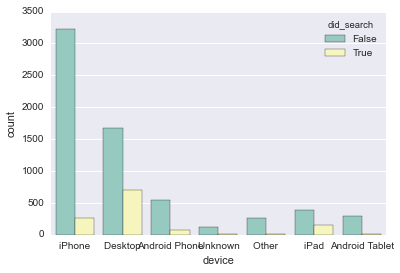

In [14]:
device_count_plots = sb.countplot(x="device", hue='did_search',palette="Set3", data=session_df)

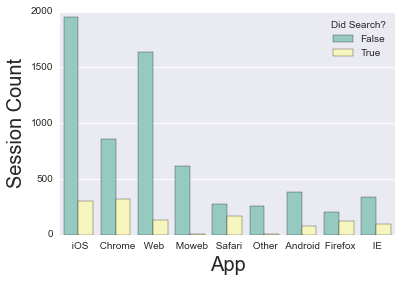

In [227]:
app_count_plots = sb.countplot(x="app", hue='did_search',palette="Set3",data=session_df)
app_count_plots.set_ylabel('Session Count', {'fontsize':20})
app_count_plots.set_xlabel('App',{'fontsize':20})
app_count_plots.legend(title='Did Search?')

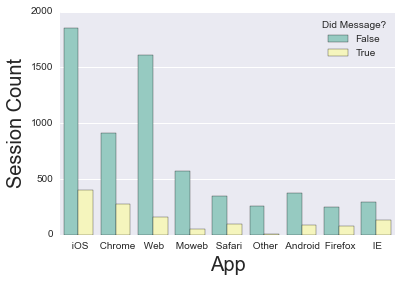

In [228]:
app_count_plots = sb.countplot(x="app", hue='sent_message',palette="Set3",data=session_df)
app_count_plots.set_ylabel('Session Count', {'fontsize':20})
app_count_plots.set_xlabel('App',{'fontsize':20})
app_count_plots.legend(title='Did Message?')

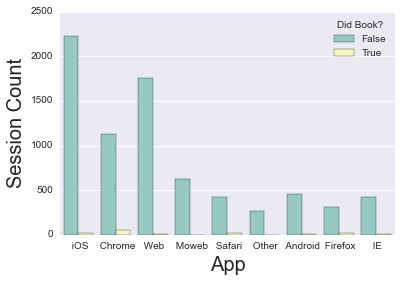

In [229]:
app_count_plots = sb.countplot(x="app", hue='sent_booking_request',palette="Set3",data=session_df)
app_count_plots.set_ylabel('Session Count', {'fontsize':20})
app_count_plots.set_xlabel('App',{'fontsize':20})
app_count_plots.legend(title='Did Book?')

In [230]:
set(session_df['device'])

{'Android Phone ',
 'Android Tablet ',
 'Desktop ',
 'Other ',
 'Unknown ',
 'iPad ',
 'iPhone '}

In [225]:
lset(session_df['app'])

{' Android',
 ' Chrome',
 ' Firefox',
 ' IE',
 ' Moweb',
 ' Other',
 ' Safari',
 ' Web',
 ' iOS'}

In [233]:
len(set(session_df['id_visitor']))

630

In [118]:
uniq_len = lambda x: len(set(x))
iOS_count = lambda x: sum([' iOS' in i for i in list(x)])
iOS_percent = lambda x: sum([' iOS' in i for i in list(x)])/len(x)

iPhone_count = lambda x: sum(['iPhone ' in i for i in list(x)])
iPhone_percent = lambda x: sum(['iPhone ' in i for i in list(x)])/len(x)

values=['next_sent_booking_request', 'next_sent_message','next_did_search'],

groupby_id = session_df.groupby('id_visitor')

visitor_device_df = groupby_id.agg({'sent_booking_request': { 'count': np.sum, 'bool': lambda x: bool(np.sum(x)) },
                'sent_message': np.sum, 
                'did_search': np.sum,
                'dim_session_number': np.max,
                'session_duration': np.mean,
                'app': {'uniq': uniq_len, 'iOS #': iOS_count, 'iOS %':iOS_percent},
                'device': {'uniq': uniq_len, 'iPhone #': iPhone_count, 'iPhone %':iPhone_percent},
               }) 

visitor_device_df.tail(2)

did_search   app                 \
                                            sum iOS #     iOS % uniq   
id_visitor                                                             
fbf1b17c-0be3-4abf-8116-c6f92d24c8f8          8     0  0.000000    2   
fd61c634-6876-4c76-81b3-6da2f86a92b8         12   104  0.376812    7   

                                     sent_booking_request        sent_message  \
                                                    count   bool          sum   
id_visitor                                                                      
fbf1b17c-0be3-4abf-8116-c6f92d24c8f8                    0  False            2   
fd61c634-6876-4c76-81b3-6da2f86a92b8                    1   True           88   

                                       device                 \
                                     iPhone #  iPhone % uniq   
id_visitor                                                     
fbf1b17c-0be3-4abf-8116-c6f92d24c8f8        0  0.000000    1   
fd61c634-6876-4c76-81b3-6da2f86a92b8      175  0.634058    5   

                                     dim_session_number session_duration  
                                                   amax             mean  
id_visitor                                                                
fbf1b17c-0be3-4abf-8116-c6f92d24c8f8                 12        14.813889  
fd61c634-6876-4c76-81b3-6da2f86a92b8                276         6.155495

In [235]:
visitor_device_df.columns = ['Search #',
                             'iOS Session #' ,
                             'iOS Session %',
                             'Unique App #',
                             'Bookings #',
                             'Did Book At least once',
                             'Message #',
                             'iPhone Session #' ,
                             'iPhone Session %',
                             'Unique Device #',
                             'Total Session Count',
                             'Session Length Mean',
                            ]
visitor_device_df.reset_index(level=0, inplace=True)
visitor_device_df.tail(2)

,id_visitor,Search #,iOS Session #,iOS Session %,Unique App #,Bookings #,Did Book At least once,Message #,iPhone Session #,iPhone Session %,Unique Device #,Total Session Count,Session Length Mean
628,fbf1b17c-0be3-4abf-8116-c6f92d24c8f8,8,0,0.000000,2,0,False,2,0,0.000000,1,12,14.813889
629,fd61c634-6876-4c76-81b3-6da2f86a92b8,12,104,0.376812,7,1,True,88,175,0.634058,5,276,6.155495


In [237]:
df = visitor_device_df[visitor_device_df['iOS Session #']>0]

len(set(df['id_visitor']))

71

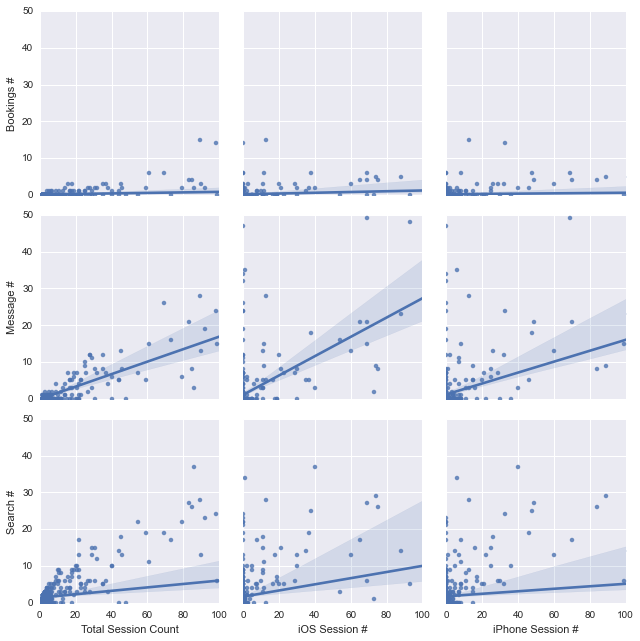

In [221]:
vars = [
    'Total Session Count',
    'iOS Session #',
    'iPhone Session #'
]

df = visitor_device_df[visitor_device_df['iOS Session #']>0]
plots = sb.pairplot(visitor_device_df,
            x_vars = vars,
            y_vars = ['Bookings #', 'Message #', 'Search #'],
            diag_kind='hist', 
            kind='reg', 
            size=3).set(ylim=(0, 50), xlim=(0,100))


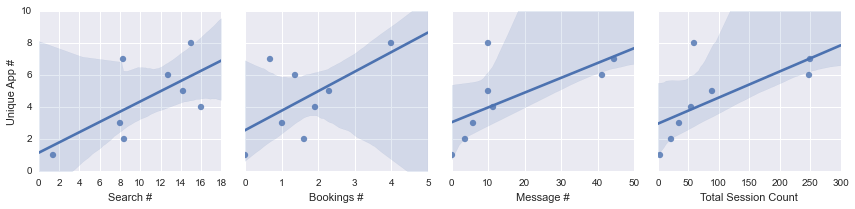

In [191]:
#Iphone users with multiple devices 

df = visitor_device_df[(visitor_device_df['iOS Session #'] > 0) ]
df = df[['Search #','Bookings #','Message #','Unique App #','Total Session Count']]
app_group_by = df.groupby('Unique App #')

df = app_group_by.mean()
df.reset_index(level=0, inplace=True)

sb.pairplot(df,
           y_vars='Unique App #',
           x_vars= ['Search #','Bookings #','Message #','Total Session Count'],
           kind='reg', 
           size=3,
           plot_kws={'scatter_kws':{"s": 40}}
           ).set(ylim=(0, 10), xlim=(0,None))

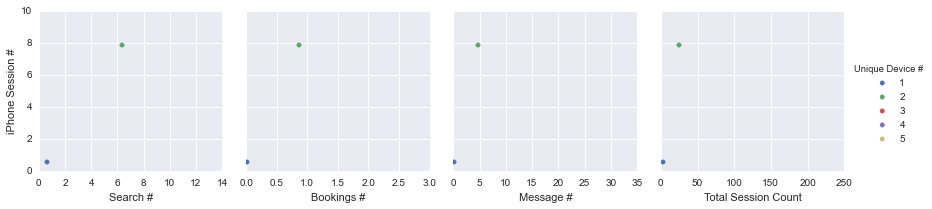

In [207]:
df = visitor_device_df
df = visitor_device_df[['Search #','Bookings #','Message #','Unique Device #','Total Session Count','iPhone Session #']]

device_group_by = df.groupby('Unique Device #')

df = device_group_by.aggregate([np.sum,np.mean])

df = device_group_by.mean()
df.reset_index(level=0, inplace=True)

sb.pairplot(df,
           y_vars='iPhone Session #',
           hue='Unique Device #',
           x_vars= ['Search #','Bookings #','Message #','Total Session Count'],
           kind='scatter', 
           size=3,
           ).set(ylim=(0, 10), xlim=(0,None))